# LoopGAN — Loop generation with StyleGAN2 and MelGAN

In [1]:
import argparse
import torch
from torchvision import utils
from model_drum import Generator
import sys
sys.path.append('./melgan')
from modules import Generator_melgan
import os, random
import librosa
import soundfile as sf
import numpy as np
from utils import *
import IPython.display as ipd

### Download a pre-trained model in advance

``` 
$ gdown -O drumbeats1_230000.pt 1B3ZWTJFuZbPPH4uIIz-pCcBTLu9-w4nw
```

In [2]:

# Constants - do not change! 
N_LATENT = 512
N_MLP = 8
SIZE_OUTPUT = 64 # size of output image
TRUNCATION = 1
TRUNCATION_MEAN = 4096
SR = 44100

# Number of samples (loops) in a batch
n_samples = 4  # batch size

# name of pre-trained StyleGAN2 model
#CHECKPOINT = "./soundcloud_can_090000.pt" 
CHECKPOINT = "./drumbeats1_230000.pt" 

# mean / std of Spectrograms of training data. used for the conversion from generated spectrograms into wav files
DATAPATH = "./data/drumbeats_1bar/" 

# name of pre-trained MelGAN model
MELGAN_MODEL_NAME = "best_netG.pt"


# Use "cuda" if you have GPUs on your machine
device_name = "cpu"


### Load models

In [3]:
# Load a StyleGAN2 model
generator = Generator(SIZE_OUTPUT, N_LATENT, N_MLP, channel_multiplier=2).to(device_name)
checkpoint = torch.load(CHECKPOINT, map_location=torch.device(device_name))

generator.load_state_dict(checkpoint["g_ema"], strict=False)

if TRUNCATION < 1:
    with torch.no_grad():
        mean_latent = generator.mean_latent(TRUNCATION_MEAN)
else:
    mean_latent = None

In [4]:
# Load a MelGAN model
def load_vocoder(device_name):
    feat_dim = 80
    mean_fp = f'{DATAPATH}/mean.mel.npy'
    std_fp = f'{DATAPATH}/std.mel.npy'
    v_mean = torch.from_numpy(np.load(mean_fp)).float().view(1, feat_dim, 1).to(device_name)
    v_std = torch.from_numpy(np.load(std_fp)).float().view(1, feat_dim, 1).to(device_name)
    
    vocoder_config_fp = './melgan/args.yml'
    vocoder_config = read_yaml(vocoder_config_fp)

    n_mel_channels = vocoder_config.n_mel_channels
    ngf = vocoder_config.ngf
    n_residual_layers = vocoder_config.n_residual_layers

    vocoder = Generator_melgan(n_mel_channels, ngf, n_residual_layers).to(device_name)
    vocoder.eval()

    vocoder_param_fp = os.path.join('./melgan', MELGAN_MODEL_NAME)
    vocoder.load_state_dict(torch.load(vocoder_param_fp, map_location=torch.device(device_name)), strict=False)

    return vocoder, v_mean, v_std

VOCODER, V_MEAN, V_STD = load_vocoder(device_name)

def vocode(sample, vocoder=VOCODER, v_mean=V_MEAN, v_std=V_STD):
    de_norm = sample.squeeze(0) * v_std + v_mean
    audio_output = vocoder(de_norm)
    return audio_output

In [5]:
# To generate 4 random latent vectors (z) for morphing process

z_presets = np.random.randn(4, N_LATENT) # rondomize!

### Generation

To make it easier to handle on Max/MSP, generated loops is saved as a wav file with `n_samples` channels. (default: 4ch)

In [6]:
def cutup(samples, division, shift=0):
    print(samples.shape)
    length = samples.shape[-1]
    num_sample = samples.shape[0]
    output = torch.tensor(samples)

    indices = np.linspace(0, length, num = division, endpoint = True, dtype = int)
    # indices = sorted(random.choices(np.arange(length), k=division))
#    indices = np.insert(indices, 0, 0)
#    indices = np.append(indices, length)
    print(indices)

    for i in range(division+1):
        random_shift = random.randint(0,num_sample)
        start, end = indices[i], indices[i+1]
        start2 =  max(0, start - random.randint(0, shift))  
        end2 = start2 + (end - start)
        for j in range(num_sample):
            high = random.randint(0, samples.shape[1])
            output[j,:,:high,start:end] = samples[(random_shift + j)%num_sample,:,:high,start2:end2]
            output[j,:,high:,start:end] = samples[(random_shift + j + 1)%num_sample,:,high:,start2:end2]
            
    return output

In [7]:
from pydub import AudioSegment

# Interpolation of z 
def get_center_z(x, y):
    assert x >= 0 and x <= 1.0
    assert y >= 0 and y <= 1.0

    z = (1-x) * (1-y) * z_presets[0] + x * (1-y) * z_presets[1] + (1-x) * y * z_presets[2] + x * y * z_presets[3]
    z = torch.tensor(z, device=device_name).double()
    z = z.repeat(n_samples, 1)
    return z    

# main function
# g_ema: stylegan generator
# center_z: to specify the input latent z 
# trucation: GAN trucation value
# variation: the scale of noise added to center_z (= vatiation in a batch)
def generate(g_ema=generator, center_z = None, truncation=TRUNCATION, variation=0.10, division=3, shift=0):
    
    with torch.no_grad():
        g_ema.eval()
        
        if center_z is None:
            # random init
            sample_z = torch.randn(1, N_LATENT, device=device_name)
            sample_z = sample_z.repeat(n_samples, 1) +  torch.randn(n_samples, N_LATENT, device=device_name) * variation
        else:
            # use specific latent z
            sample_z = center_z + torch.randn(n_samples, N_LATENT, device=device_name) * variation
        sample_z = sample_z.float()
        
        # Generate!!!
        sample, _ = g_ema([sample_z], truncation=truncation, truncation_latent=mean_latent)
      
        sample = cutup(sample, division, shift);   

        # Saving tje generated spectrogram image
        randid = random.randint(0, 10000)
        imagepath = f'/tmp/img_{randid}.png'
        utils.save_image(sample, imagepath, nrow=1, normalize=True, range=(-1, 1))
    

        # Saving multi channel audio file
        filepath = f'/tmp/gem_{randid}.wav'
        channels = [] 
        numpy_chs = []  # for numpy array
        # convert (n_samples) spectrogram into audio, one by one 
        for i in range(n_samples):
            audio_output = vocode(sample[i])
            audio_output = audio_output.squeeze().detach().cpu().numpy() 
            numpy_chs.append(audio_output)
            
            channel = AudioSegment( (audio_output*np.iinfo(np.int16).max).astype("int16").tobytes(), sample_width=2, # 16 bit 
                    frame_rate=SR, channels=1)
            channels.append(channel)
        # save as a wav file with (n_samples) channel
        multich = AudioSegment.from_mono_audiosegments(*channels)
        multich.export(filepath, format="wav")
        
        return filepath, imagepath, np.array(numpy_chs)


### Test

Let's generate random loops with random input latent z

torch.Size([4, 1, 80, 320])
[  0   0  64 128 192 256 320 320]


/var/folders/2s/l0bgs2l55652xxz80ph77f2m0000gn/T/ipykernel_33981/800439623.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(samples)
/Users/nao/opt/anaconda3/envs/aidj3/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


shape: (4, 81920)


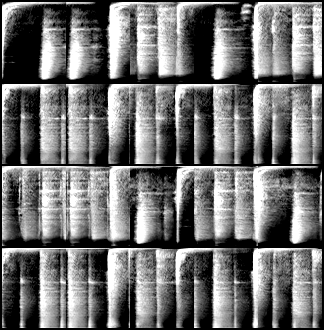

In [8]:
# random generation 
_,  imagepath, audio_output = generate(variation=1.5, division=6, shift=30)

print("shape:", audio_output.shape)

# display the generated spectrogram
ipd.display(ipd.Image(filename=imagepath))


# play the first channel
ipd.display(ipd.Audio(audio_output[0], rate=SR))

#### Stereo effect
Small gausian noise can be added to the input latent vector z. If you play the first and second sample in the generated batch as a stereo audio file, then you'll get an interesting stereo effect. Try different numbers! 

torch.Size([4, 1, 80, 320])
[  0   0 160 320 320]


/var/folders/2s/l0bgs2l55652xxz80ph77f2m0000gn/T/ipykernel_33981/800439623.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(samples)


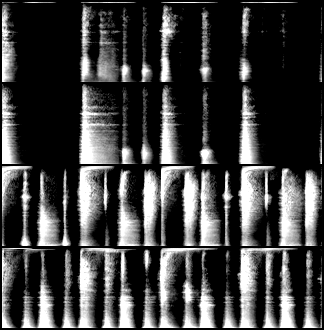

In [9]:
_,  imagepath, audio_output = generate(variation=0.35)

ipd.display(ipd.Audio(audio_output[:2], rate=SR)) # stereo 

ipd.display(ipd.Image(filename=imagepath))


### OSC server/client for Max/MSP

In [10]:
from pythonosc import dispatcher
from pythonosc import osc_server, udp_client
import os, random

# client
client = udp_client.SimpleUDPClient('127.0.0.1', 10018)

# generate randomly
def generate_random(unused_addr, variation=0.1, division=1, shift=0):
    audiopath, imagepath, _ = generate(center_z=None, variation=variation, division=division, shift=shift) # random sample
    client.send_message("/generated", (audiopath, imagepath)) 
    client.send_message("/generated", (audiopath, imagepath)) 

# morphing
def generate_xy(unused_addr, x, y, variation, division=1, shift=0):
    z_center = get_center_z(x, y)
    audiopath, imagepath, _  = generate(center_z=z_center, variation=variation, division=division, shift=shift) # random sample
    client.send_message("/generated", (audiopath, imagepath))
    client.send_message("/generated", (audiopath, imagepath)) 

# server
dispatcher = dispatcher.Dispatcher()
dispatcher.map("/generate_random", generate_random)
dispatcher.map("/generate_xy", generate_xy)

server = osc_server.ThreadingOSCUDPServer(
    ('localhost', 10015), dispatcher)
print("Serving on {}".format(server.server_address))
server.serve_forever()




Serving on ('127.0.0.1', 10015)
torch.Size([4, 1, 80, 320])
[  0   0  35  71 106 142 177 213 248 284 320 320]


/var/folders/2s/l0bgs2l55652xxz80ph77f2m0000gn/T/ipykernel_33981/800439623.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(samples)


torch.Size([4, 1, 80, 320])
[  0   0  35  71 106 142 177 213 248 284 320 320]
torch.Size([4, 1, 80, 320])
[  0   0  29  58  87 116 145 174 203 232 261 290 320 320]
